# Introduction

In this notebook, I continue from the EDA carried out by Imran. In his notebook, he perfoms some feature analysis as well as some statistical tests to test whether the pollution data displays stationarity. These tests that indicate stationarity are important as this is a very important assumption in Vector Autoregressive (VAR) models.

VAR models are the multivariate generalisation of univariate autoregressive time series models. In general, the prediction vector $y_{t}$ depennds on its $p$ previous values $y_{t-1}, y_{t-2},...,y_{t-p}$. These quantities are related in a linear form as shown below $$y_{t} = a_{0} + \sum_{j=1}^{p}A_{j}y_{t-j} + u_{t}$$
where $y_{t} \in \mathbb{R}^{n}$ vector containing the values of the different time series at time $T=t$, $a_{0} \in \mathbb{R}^{n}$ is a vector of constants, $A_{1} \in \mathbb{R}^{n \times n}$ are the autoregressive coefficients that and $u_{t} \in \mathbb{R}^{n}$ represents noise. 

The ultimate goal is to find the "best" lag $p$ and to fit the ``best" possible autoregressive coefficients. We discuss what is mean by the term "best" in terms of lag and autoregressive coefficients.


First, we just do some preprocessing that was already carried out in the previous notebook.

In [ ]:
import numpy as np
import pandas as pd
import pickle 
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [22]:
with open('../data/raw_data.pickle', 'rb') as f:
    df = pickle.load(f)

In [92]:
df

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,2,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,2,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,2,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,2,6.25,2,0
...,...,...,...,...,...,...,...,...,...
43795,2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,3,231.97,0,0
43796,2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,3,237.78,0,0
43797,2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,3,242.70,0,0
43798,2014-12-31 22:00:00,8.0,-22,-4.0,1034.0,3,246.72,0,0


In [24]:
df = df.rename_axis('date').reset_index()

In [25]:
mapping = {
    'NE': 1,
    'SE': 2,
    'NW': 3,
    'cv': 4
}

df.wnd_dir = df.wnd_dir.map(mapping)
df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,2,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,2,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,2,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,2,6.25,2,0


## Chosing The Lag $p$

In our model, it is rather pertinent to choose a good value for $p$. By a good value, we mean a value that is long enough such that we can effectively utilise the data we have acquired but not so large such that we creat a model that overfits.

A useful way to see what lag we should use is by plotting autocorrelation function (ACF) and partial autocorrelation function (PACF) plots. These plots tell us how correlated (~ "predictive") the values at time $T=t-p$ are to values at $T=t$. More specifically, ACF plots show the correlation of a time series with itself at different lags. Alternatively, PACF plots show the correlation of a time series with itself at different lags but without for any correlation between observations of short lags. It turns out that PACF are usually more descriptive so we only plot those below.

Note that as we are working with multiple times series (population, dew, temp, etc), we need to the PACF plots for each.

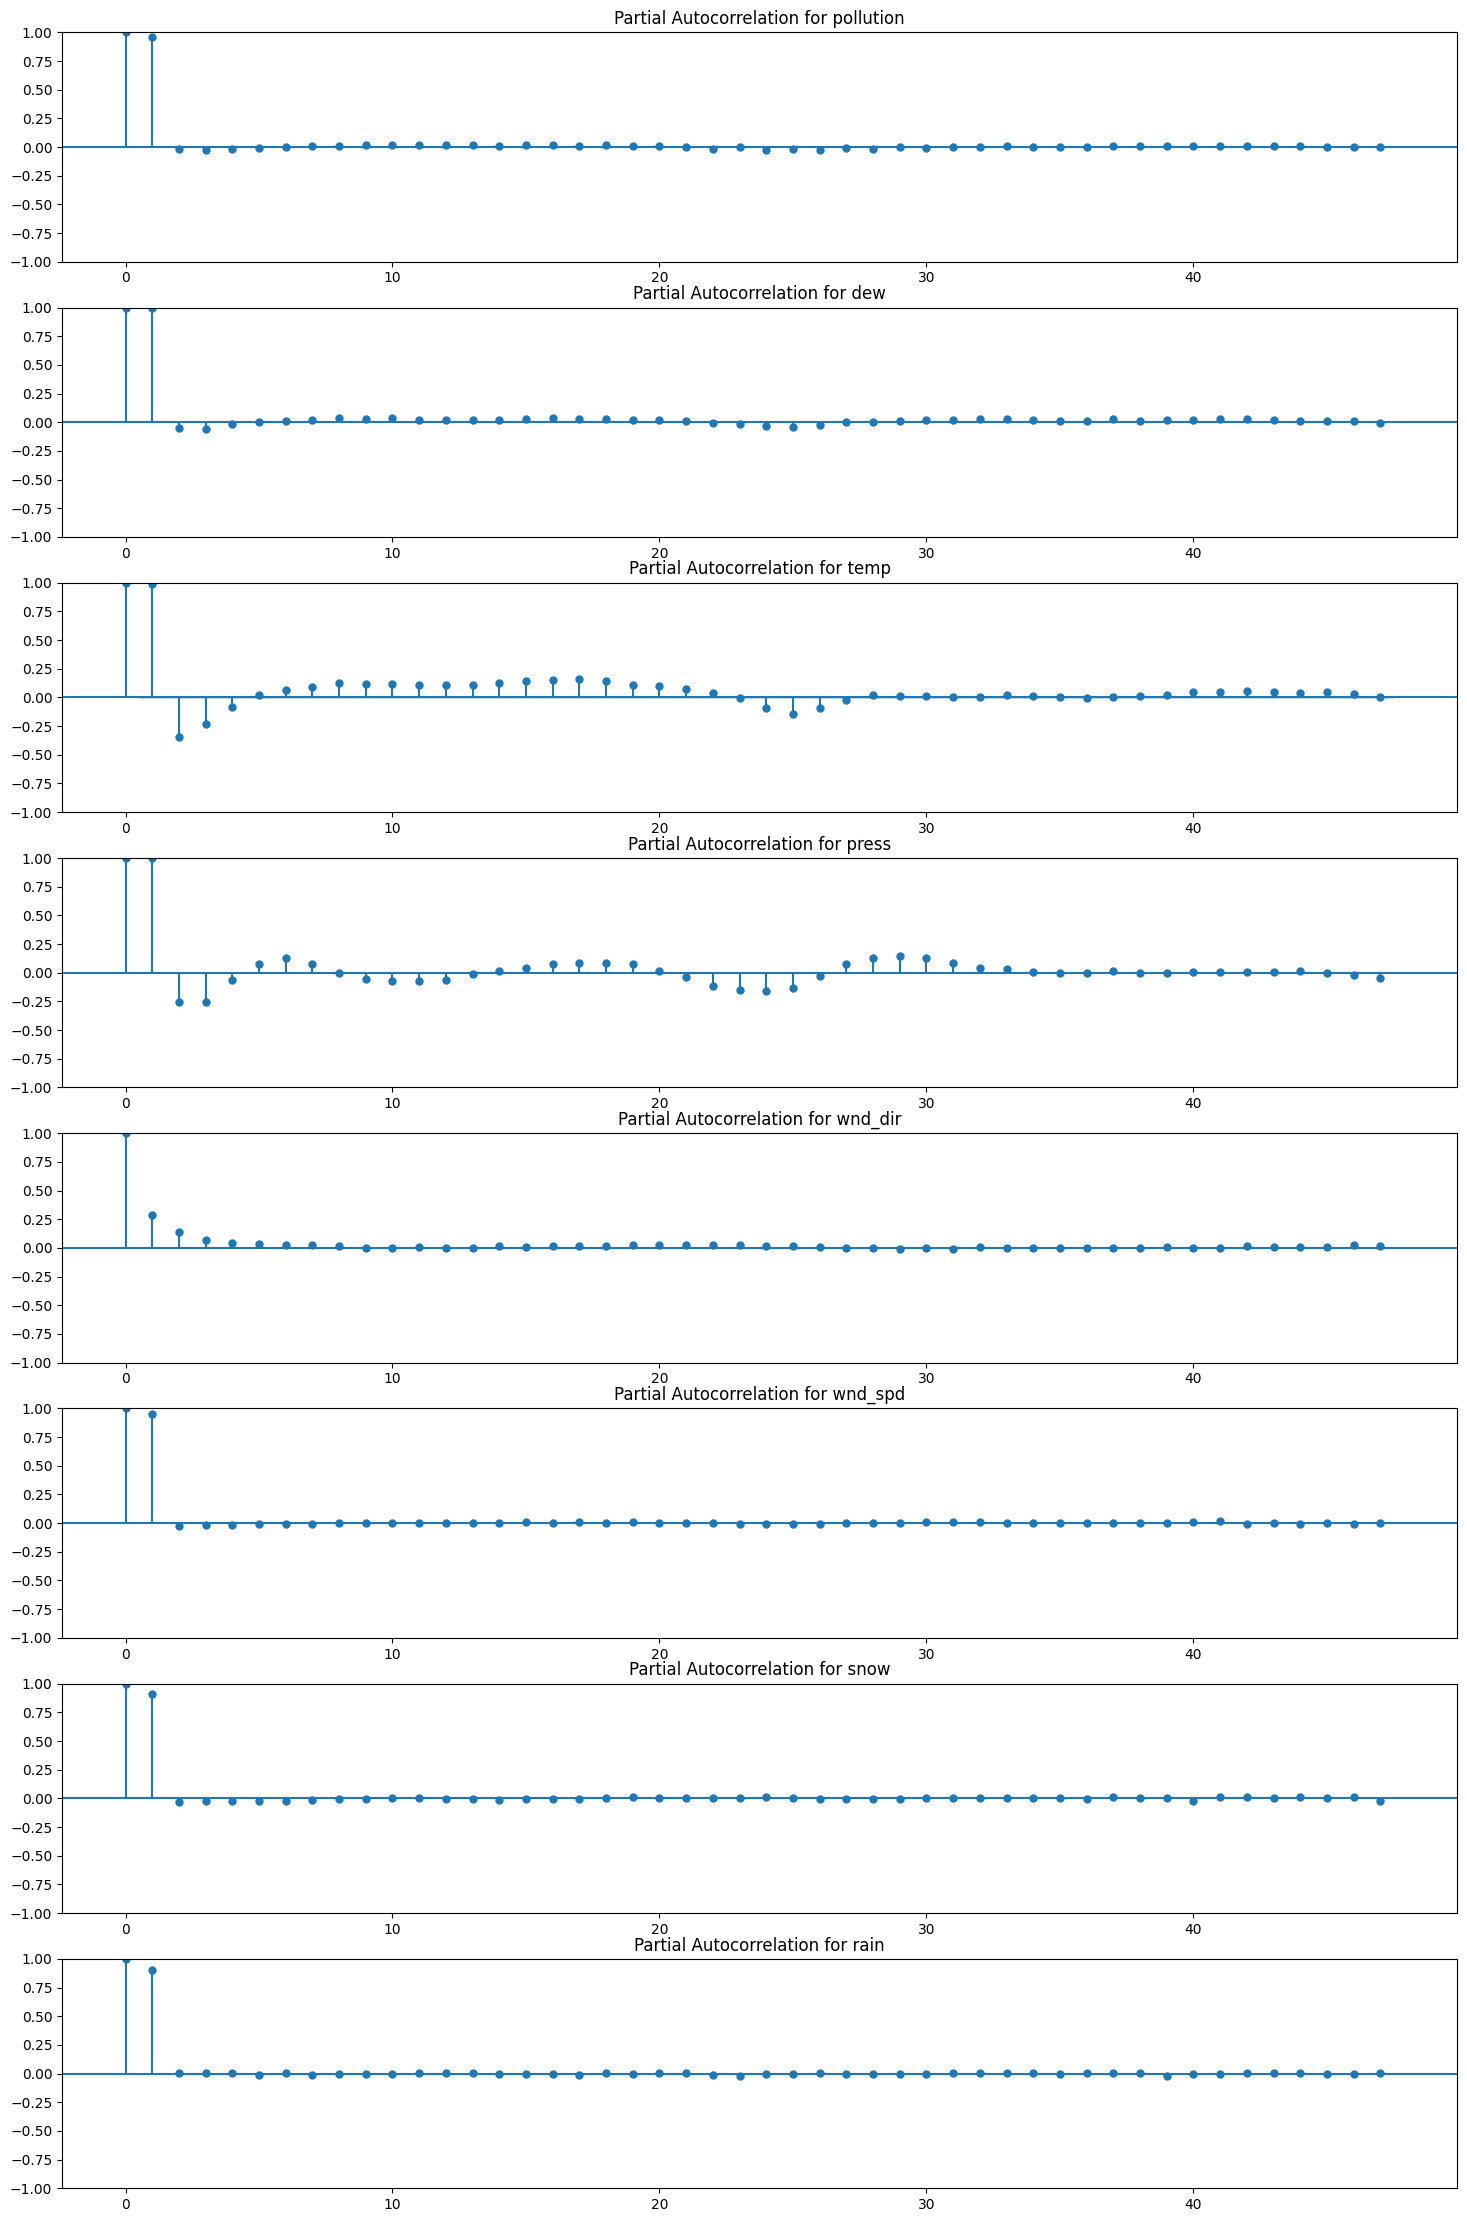

In [ ]:
fig, axs = plt.subplots(8, 1, figsize=(18,28))

columns = list(df)
columns.pop(0)
for i, x in enumerate(columns):
    plot_pacf(df[x], axs[i], title="Partial Autocorrelation for " + x)

# ANALYSIS
We see that $p$ should be pretty small. We see that there is some seasonal effect for pressure. Maybe we could do some modular arithmetic lag. I am not sure but anyway, after $p=4$, I don't think we have anything significant. #Expand on this

Look up what the context means

## Finding Optimal Lags
While these PACF plots do provide a heuristic for finding a good choice for out lag $p$, we can use other methods that provide a more systematic approach. First, we look at some error metrics on validation data. In particular, we look at mean absolute error (MAE) and root mean square error (RMSE). Their formulae are below:
* $MAE = \frac{1}{n} \sum_{j=1}^{n} |y_{t} - \hat{y_{t}}|$
* $RMSE = \frac{1}{n} \sqrt{\sum_{j=1}^{n}(y_{t} - \hat{y_{t}})^{2}}$

While there are other metrics, I chose both of these as they have the same "units" as opposed to percentages or something like mean squared error.
To do this, we create a 80/10/10  train, validation, test split. We will train a model with the training data. For each lag $p$, we will use ``results.forecast`` on validation data using rolling window validation. We will take all of these errors and sum them. We then iterate this process for different values of $p$.

In [323]:
forecast_length = len(df) // 10

# Creating an 80/10/10 train, validation, test split 
# We have that the first 10% of the dataset is validation so we can use the test data effectively when forecasting
# train_df, validation_df, test_df = df[0: 8*forecast_length], df[8*forecast_length: 9*forecast_length], df[9*forecast_length:]
validation_df, train_df, test_df = df[0: forecast_length], df[forecast_length: 9*forecast_length], df[9*forecast_length:]

train_df = train_df.drop("date", axis=1)
validation_df = validation_df.drop("date", axis=1)
test_df = test_df.drop("date", axis=1)

In [324]:
# Train the model
model = VAR(train_df)

In [346]:
# Finding the MAE error and RMSE error with respect to different lags
sums_of_errors1, sums_of_errors = [], []
for j in range(1, 30):
    results = model.fit(j)

    validation_length = 100
    comparison_length = 10
    arr1, arr = [], []
    for i in range(len(validation_df) - validation_length - comparison_length):
        arr1.append(mean_absolute_error(results.forecast(validation_df.values[i:i + validation_length], steps=comparison_length), validation_df.values[i + validation_length + 1: i + validation_length + 1 + comparison_length]))
        arr.append(root_mean_squared_error(results.forecast(validation_df.values[i:i + validation_length], steps=comparison_length), validation_df.values[i + validation_length + 1: i + validation_length + 1 + comparison_length]))

    sums_of_errors1.append(sum(arr1))
    sums_of_errors.append(sum(arr))

In [343]:
len(results.forecast(validation_df.values[i:i + validation_length], steps=comparison_length))

10

In [345]:
len(validation_df.values[i + validation_length + 1: i + validation_length + comparison_length + 1])

10

In [333]:
len(validation_df.values[0 + validation_length + 1: 0 + validation_length + 1 + comparison_length])

10

Text(0, 0.5, 'Total Root Mean Squared Error')

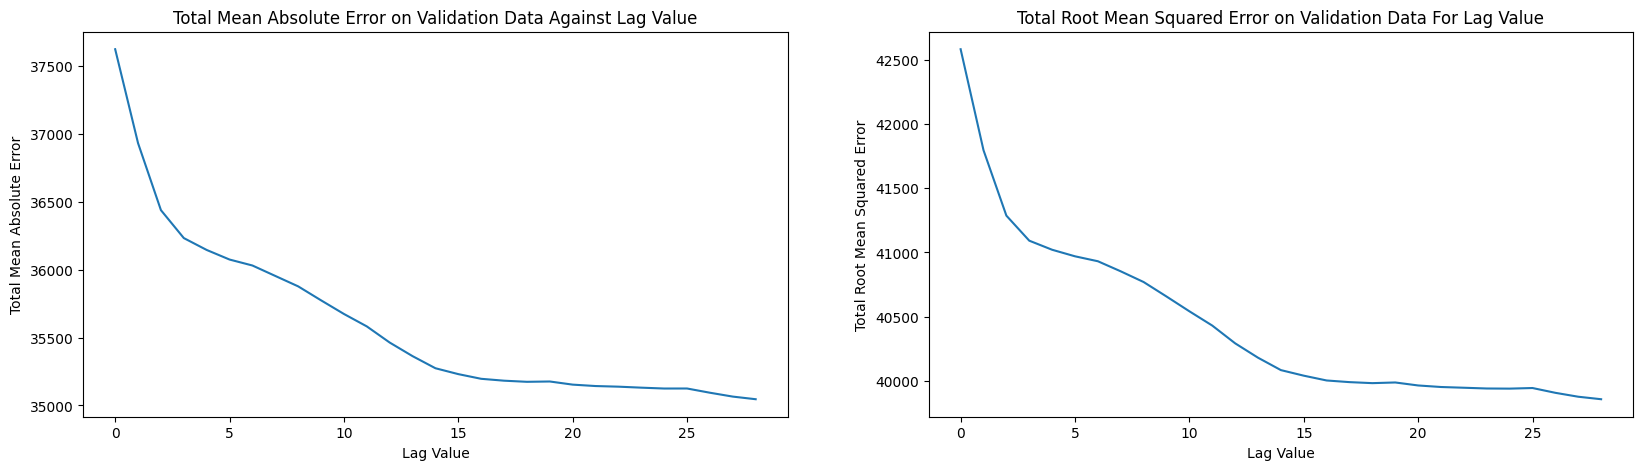

In [347]:
# Plotting the total errors
fig, axs = plt.subplots(1, 2, figsize=(20,5))

axs[0].plot([i for i in range(len(sums_of_errors1))], sums_of_errors1)
axs[0].set_title("Total Mean Absolute Error on Validation Data Against Lag Value")
axs[0].set_xlabel("Lag Value")
axs[0].set_ylabel("Total Mean Absolute Error")
axs[1].plot([i for i in range(len(sums_of_errors))], sums_of_errors)
axs[1].set_title("Total Root Mean Squared Error on Validation Data For Lag Value")
axs[1].set_xlabel("Lag Value")
axs[1].set_ylabel("Total Root Mean Squared Error")

From these plots, it seems that a lag of $p=23$ minimises our error when we test against our validation data. This some what contradicts the conclusion we drew from the PACF plots. We will talk about what may be causing this apparent disagreement after looking information criteria to find an optimal $p$.

We now look at using information criteria to try to determine the optimal lag. As with error metrics, there are various information criteria. Though they have different values and formulae, their goal is singular: to measure how well a model fits the data while penalising model complexity. In these formulas, the first term is the prediction error and the second describes the complexity of the model. This means that we are trying to minimise these quantities. Alternatively, we could take negatives of these quantities and try to maximise them. This leads to the same results and is also used. Below we list the information criteria we use and show their formulae:
* Akaike Information Criterion - $AIC = 2k - 2 \ln{(L)}$
* Schwarz’s Bayesian Information Criterion - $BIC = k\ln{(n)} - 2 \ln{(L)}$
* Hannan-Quinn Criterion - $HQIC = 2k\ln{(\ln{(n)})} - 2\ln{(L)}$
* Akaike’s Final Prediction Error Criterion - $FPE = n\log{\left ( \frac{n+k}{n-k} \right)} - 2 \ln{(L)}$

where $k$ is the number of parameters of the model, $n$ is the number of of data points and $L$ is the maximised value of the likelihood function of the model.

These formulas come from this [online textbook](https://estima.com/webhelp/topics/informationcriteria.html).

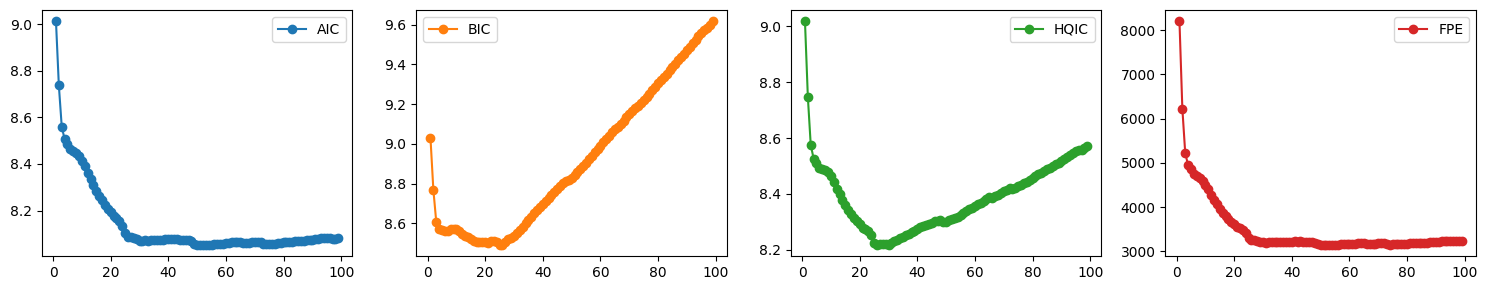

In [348]:
aic, bic, fpe, hqic = [], [], [], []
model = VAR(train_df) 
p = np.arange(1,100)
for i in p:
    result = model.fit(i)
    aic.append(result.aic)
    bic.append(result.bic)
    fpe.append(result.fpe)
    hqic.append(result.hqic)
lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                'BIC': bic, 
                                'HQIC': hqic,
                                'FPE': fpe}, 
                               index=p)    
fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharex=True)
lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
plt.tight_layout()

I think this plot is the most enlightening. It shows that each information criterion decays rapidly for lags less than four but once we reach four, the loss in information is lesser. The information criterion penalised model complexity so it seems as though the plots suggest that larger and larger models are worth this trade-off until about $p=23$. I think that a lag of $p=3$ is a good trade-off as we don't really gain as much from larger lags.

## The Granger Causality Test

The Granger causality test

We can 

In [349]:
model = VAR(train_df)
var_model = model.fit(23)

In [350]:
var_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 19, Nov, 2024
Time:                     02:54:49
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    8.51067
Nobs:                     35017.0    HQIC:                   8.26689
Log likelihood:          -538762.    FPE:                    3473.62
AIC:                      8.15295    Det(Omega_mle):         3330.24
--------------------------------------------------------------------
Results for equation pollution
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 4.995520        30.374678            0.164           0.869
L1.pollution          0.985828         0.005392          182.818           0.000
L1.dew                1.986574         0.107915         

In [351]:
forecast_var = pd.DataFrame(var_model.forecast(train_df.values, 
                                              steps=forecast_length), 
                           columns=train_df.columns, 
                           index=test_df.index)
forecast_var = forecast_var.rename(columns={c: c+'-VAR' for c in forecast_var.columns})

In [352]:
forecast_var

,pollution-VAR,dew-VAR,temp-VAR,press-VAR,wnd_dir-VAR,wnd_spd-VAR,snow-VAR,rain-VAR
39420,59.569299,20.625589,25.503638,1003.913968,2.722659,2.799832,0.051071,0.136131
39421,62.110230,20.225436,27.071847,1003.594441,2.732677,6.104186,0.020282,0.197654
39422,64.378685,19.762270,28.118912,1003.267833,2.496430,8.890164,0.014127,0.311214
39423,65.128779,19.205601,28.840465,1002.751231,2.388998,10.786577,0.003122,0.281345
39424,65.782088,18.979514,28.906014,1002.240895,2.619708,12.477202,0.022703,0.286438
...,...,...,...,...,...,...,...,...
43795,94.581378,2.899621,13.417159,1015.669026,2.629084,23.062261,0.043735,0.212131
43796,94.581989,2.898876,13.416527,1015.669502,2.629088,23.062720,0.043738,0.212122
43797,94.582600,2.898132,13.415896,1015.669978,2.629093,23.063178,0.043741,0.212113
43798,94.583211,2.897388,13.415265,1015.670454,2.629098,23.063637,0.043745,0.212104


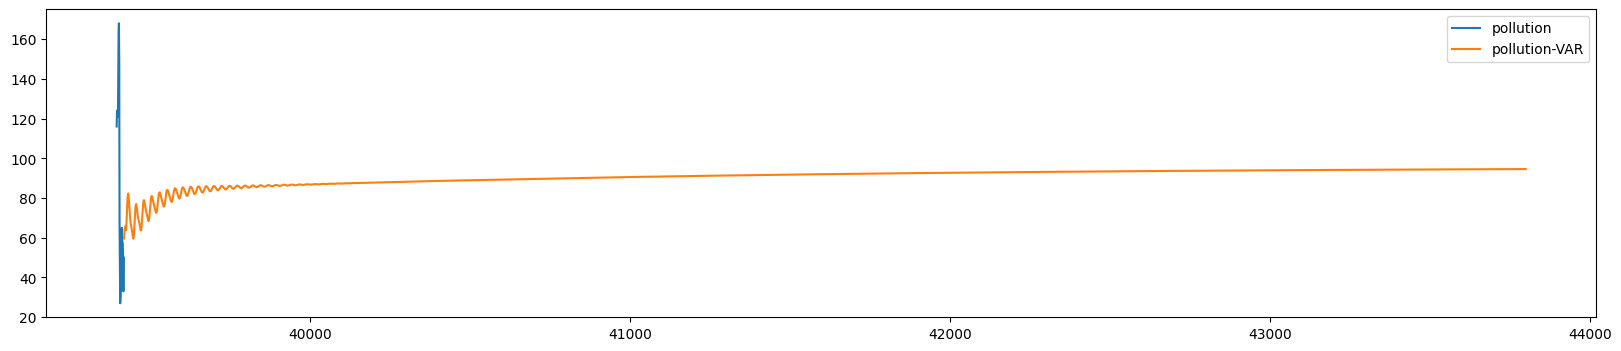

In [353]:
fig, ax = plt.subplots(figsize=[20, 4])
# pd.concat([train_df[["pollution"]], forecast_var[["pollution"+'-VAR']], test_df["pollution"]], axis=1).plot(ax=ax)
pd.concat([train_df["pollution"][-23:], forecast_var[["pollution"+'-VAR']]], axis=1).plot(ax=ax)

plt.show()

In [360]:
forecast = var_model.forecast(train_df.values[-23:], 5)
forecast[0]

array([5.95692987e+01, 2.06255885e+01, 2.55036376e+01, 1.00391397e+03,
       2.72265900e+00, 2.79983194e+00, 5.10708119e-02, 1.36130938e-01])

In [292]:
train_df["pollution"][-23:].values

array([116., 124., 122., 122., 121., 141., 163., 168., 149.,  66.,  48.,
        27.,  30.,  34.,  43.,  45.,  65.,  59.,  58.,  57.,  52.,  33.,
        50.])

In [ ]:
fig, ax = plt.subplots(figsize=[20, 4])
# pd.concat([train_df[["pollution"]], forecast_var[["pollution"+'-VAR']], test_df["pollution"]], axis=1).plot(ax=ax)
pd.concat([train_df["pollution"][-23:], forecast_var[["pollution"+'-VAR']]], axis=1).plot(ax=ax)

plt.show()